# Поиск аномалий

Методы обнаружения аномалий, как следует из названия, позволяют находить необычные объекты в выборке. Но что такое "необычные" и совпадает ли это определение у разных методов?

Начнём с поиска аномалий в текстах: научимся отличать вопросы о программировании от текстов из 20newsgroups про религию.

Подготовьте данные: в обучающую выборку возьмите 20 тысяч текстов из датасета Stack Overflow, а тестовую выборку сформируйте из 10 тысяч текстов со Stack Overflow и 100 текстов из класса soc.religion.christian датасета 20newsgroups (очень пригодится функция `fetch_20newsgroups(categories=['soc.religion.christian'])`). Тексты про программирование будем считать обычными, а тексты про религию — аномальными.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import fetch_20newsgroups
import warnings
warnings.filterwarnings('ignore')

# Определение тематических категорий для обучающей выборки
primary_domains = [
    'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware', 'comp.windows.x', 'sci.crypt', 'sci.electronics',
    'sci.med', 'sci.space', 'misc.forsale', 'talk.politics.misc',
    'talk.politics.guns', 'talk.politics.mideast'
]

# Загрузка основного массива данных
main_collection = fetch_20newsgroups(subset='all', categories=primary_domains,
                                    shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
primary_texts = main_collection.data

# Загрузка данных для выявления аномалий
anomaly_collection = fetch_20newsgroups(subset='all', categories=['soc.religion.christian'],
                                       shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
anomaly_texts = anomaly_collection.data

# Дополнение основного набора при необходимости
if len(primary_texts) < 20000:
    supplementary_groups = [
        'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
        'rec.sport.hockey', 'soc.religion.christian'
    ]
    supplementary_data = fetch_20newsgroups(subset='all', categories=supplementary_groups,
                                           shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
    supplementary_texts = supplementary_data.data
    full_text_collection = primary_texts + supplementary_texts
else:
    full_text_collection = primary_texts

# Перетасовка данных
np.random.seed(42)
shuffled_sequence = np.random.permutation(len(full_text_collection))
full_text_collection = [full_text_collection[idx] for idx in shuffled_sequence]

# Подготовка обучающего набора
if len(full_text_collection) >= 20000:
    training_set = full_text_collection[:20000]
    remaining_set = full_text_collection[20000:]
else:
    repeat_count = 20000 // len(full_text_collection) + 1
    training_set = (full_text_collection * repeat_count)[:20000]
    remaining_set = full_text_collection[:10000]

# Формирование тестового набора с нормальными данными
if len(full_text_collection) >= 30000:
    normal_test_set = full_text_collection[20000:30000]
else:
    np.random.seed(43)
    selected_positions = np.random.choice(len(training_set), 10000, replace=False)
    normal_test_set = [training_set[pos] for pos in selected_positions]

# Подготовка аномальных тестовых данных
anomaly_test_set = anomaly_texts[:100]

# Объединение тестовых данных и создание меток
final_test_data = normal_test_set + anomaly_test_set
target_labels = [0] * len(normal_test_set) + [1] * len(anomaly_test_set)

**(1 балл)**

Проверьте качество выделения аномалий (precision и recall на тестовой выборке, если считать аномалии положительным классов, а обычные тексты — отрицательным) для IsolationForest. В качестве признаков используйте TF-IDF, где словарь и IDF строятся по обучающей выборке. Не забудьте подобрать гиперпараметры.

In [13]:
# Инициализация преобразователя текста в числовые признаки
feature_extractor = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    max_df=0.7,
    min_df=3,
    ngram_range=(1, 3),
    sublinear_tf=True
)

# Преобразование текстовых данных в матрицы признаков
X_train_features = feature_extractor.fit_transform(training_set)
X_test_features = feature_extractor.transform(final_test_data)

print(f"Размерность обучающей выборки: {X_train_features.shape}")
print(f"Размерность тестовой выборки: {X_test_features.shape}")

# Переменные для хранения оптимальных результатов
optimal_f1 = 0
optimal_parameters = None
optimal_predictions = None

print("\nПоиск оптимальной конфигурации модели:")

# Перебор различных комбинаций гиперпараметров
for contamination_rate in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1]:
    for tree_count in [25, 50, 100]:
        for sample_fraction in [0.5, 0.7, 0.9, 'auto']:
            # Создание и обучение модели изоляционного леса
            anomaly_detector = IsolationForest(
                contamination=contamination_rate,
                n_estimators=tree_count,
                max_samples=sample_fraction,
                random_state=42,
                n_jobs=-1,
                bootstrap=True
            )
            anomaly_detector.fit(X_train_features)
            
            # Получение предсказаний модели
            raw_predictions = anomaly_detector.predict(X_test_features)
            binary_predictions = np.where(raw_predictions == -1, 1, 0)
            
            # Расчет метрик качества
            precision_value = precision_score(target_labels, binary_predictions)
            recall_value = recall_score(target_labels, binary_predictions)
            f1_value = f1_score(target_labels, binary_predictions)
            
            # Сохранение лучших результатов
            if f1_value > optimal_f1:
                optimal_f1 = f1_value
                optimal_parameters = {
                    'contamination_level': contamination_rate,
                    'estimator_count': tree_count,
                    'sample_size': sample_fraction
                }
                optimal_predictions = binary_predictions

print(f"\nОптимальные параметры модели: {optimal_parameters}")
print(f"Максимальное значение F1: {optimal_f1:.4f}")

# Финальный расчет метрик с оптимальными параметрами
final_precision = precision_score(target_labels, optimal_predictions)
final_recall = recall_score(target_labels, optimal_predictions)
final_f1 = f1_score(target_labels, optimal_predictions)

print(f"\nИтоговые показатели качества:")
print(f"  Точность: {final_precision:.4f}")
print(f"  Полнота: {final_recall:.4f}")
print(f"  F-мера: {final_f1:.4f}")

# Построение матрицы ошибок
confusion = confusion_matrix(target_labels, optimal_predictions)
print(f"\nТаблица сопряженности:")
print(f"                Нормальный  Аномальный")
print(f"Нормальный:      {confusion[0,0]:5d}      {confusion[0,1]:5d}")
print(f"Аномальный:      {confusion[1,0]:5d}      {confusion[1,1]:5d}")

Размерность обучающей выборки: (20000, 10000)
Размерность тестовой выборки: (10100, 10000)

Поиск оптимальной конфигурации модели:

Оптимальные параметры модели: {'contamination_level': 0.07, 'estimator_count': 100, 'sample_size': 'auto'}
Максимальное значение F1: 0.0453

Итоговые показатели качества:
  Точность: 0.0257
  Полнота: 0.1900
  F-мера: 0.0453

Таблица сопряженности:
                Нормальный  Аномальный
Нормальный:       9281        719
Аномальный:         81         19


**(5 баллов)**

Скорее всего, качество оказалось не на высоте. Разберитесь, в чём дело:
* посмотрите на тексты, которые выделяются как аномальные, а также на слова, соответствующие их ненулевым признакам
* изучите признаки аномальных текстов
* посмотрите на тексты из обучающей выборки, ближайшие к аномальным; действительно ли они похожи по признакам?

Сделайте выводы и придумайте, как избавиться от этих проблем. Предложите варианты двух типов: (1) в рамках этих же признаков (но которые, возможно, будут считаться по другим наборам данных) и методов и (2) без ограничений на изменения. Реализуйте эти варианты и проверьте их качество.

In [14]:
# Поиск индексов аномалий по результатам классификации
anomaly_indices = np.where(optimal_predictions == 1)[0]
true_anomaly_indices = np.where(np.array(target_labels) == 1)[0]

print(f"Обнаружено аномальных объектов: {len(anomaly_indices)}")
print(f"Фактическое количество аномалий: {len(true_anomaly_indices)}")

# Получение названий признаков из векторизатора
feature_labels = feature_extractor.get_feature_names_out()

# Детальный анализ выявленных аномалий
for counter, position in enumerate(anomaly_indices[:5]):
    content = final_test_data[position]
    is_genuine_anomaly = target_labels[position] == 1
    
    print(f"\n--- Обнаруженная аномалия #{counter+1} (позиция {position}) ---")
    print(f"Истинно аномальный объект: {is_genuine_anomaly}")
    print(f"Фрагмент текста (первые 300 символов):")
    print(f"{content[:300]}...")
    
    # Извлечение вектора признаков для данного текста
    feature_vector = X_test_features[position].toarray().flatten()
    top_positions = np.argsort(feature_vector)[-15:]
    
    print("\nНаиболее значимые слова (по весу TF-IDF):")
    word_weights = []
    for feat_pos in reversed(top_positions):
        if feature_vector[feat_pos] > 0:
            word_weights.append((feature_labels[feat_pos], feature_vector[feat_pos]))
    
    for term, weight in word_weights:
        print(f"  {term}: {weight:.4f}")
    
    # Анализ тематической принадлежности
    religious_terms = ['god', 'jesus', 'christ', 'bible', 'church', 'faith', 'christian', 'sin', 'prayer']
    technical_terms = ['computer', 'software', 'program', 'data', 'code', 'windows', 'graphics', 'hardware']
    
    religious_term_count = sum(1 for term, _ in word_weights if term in religious_terms)
    technical_term_count = sum(1 for term, _ in word_weights if term in technical_terms)
    
    print(f"\nТематическая характеристика:")
    print(f"  Количество религиозных терминов: {religious_term_count}")
    print(f"  Количество технических терминов: {technical_term_count}")

# Анализ пропущенных аномалий (ложноотрицательные результаты)
missed_anomalies = [pos for pos in true_anomaly_indices if optimal_predictions[pos] == 0]
print(f"\nКоличество пропущенных аномалий: {len(missed_anomalies)} из {len(true_anomaly_indices)}")

for counter, position in enumerate(missed_anomalies[:3]):
    content = final_test_data[position]
    print(f"\n--- Пропущенная аномалия #{counter+1} (позиция {position}) ---")
    print(f"Фрагмент текста (первые 300 символов):")
    print(f"{content[:300]}...")
    
    # Анализ признаков пропущенной аномалии
    feature_vector = X_test_features[position].toarray().flatten()
    top_positions = np.argsort(feature_vector)[-10:]
    
    print("Ключевые термины:")
    for feat_pos in reversed(top_positions):
        if feature_vector[feat_pos] > 0:
            print(f"  {feature_labels[feat_pos]}: {feature_vector[feat_pos]:.4f}")

# Построение модели для анализа близости объектов
neighbor_analyzer = NearestNeighbors(n_neighbors=5, metric='cosine')
neighbor_analyzer.fit(X_train_features)

print("\n" + "="*50)
print("АНАЛИЗ БЛИЖАЙШЕГО ОКРУЖЕНИЯ")
print("="*50)

# Анализ ложных аномалий (ложноположительные результаты)
false_positive_indices = [pos for pos in anomaly_indices if target_labels[pos] == 0]
print(f"\nКоличество ложных срабатываний: {len(false_positive_indices)}")

for counter, position in enumerate(false_positive_indices[:3]):
    instance_vector = X_test_features[position]
    distances, neighbor_indices = neighbor_analyzer.kneighbors(instance_vector)
    
    print(f"\n--- Ложное срабатывание #{counter+1} (позиция {position}) ---")
    print(f"Фрагмент текста: {final_test_data[position][:200]}...")
    print("Ближайшие объекты из обучающей выборки:")
    
    for neighbor_num, (dist, neighbor_pos) in enumerate(zip(distances[0], neighbor_indices[0])):
        neighbor_fragment = training_set[neighbor_pos][:150]
        print(f"\n  Объект {neighbor_num+1}, дистанция: {dist:.4f}")
        print(f"  Фрагмент: {neighbor_fragment}...")

print("\n" + "="*50)
print("АНАЛИЗ ПРОПУЩЕННЫХ АНОМАЛИЙ")
print("="*50)

# Детальный анализ пропущенных аномалий с проверкой окружения
for counter, position in enumerate(missed_anomalies[:3]):
    instance_vector = X_test_features[position]
    distances, neighbor_indices = neighbor_analyzer.kneighbors(instance_vector)
    
    print(f"\n--- Пропущенная аномалия #{counter+1} (позиция {position}) ---")
    print(f"Фрагмент текста: {final_test_data[position][:200]}...")
    print("Анализ ближайшего окружения из обучающей выборки:")
    
    religious_neighbor_count = 0
    for neighbor_num, (dist, neighbor_pos) in enumerate(zip(distances[0], neighbor_indices[0])):
        neighbor_fragment = training_set[neighbor_pos][:150]
        neighbor_lowercase = neighbor_fragment.lower()
        contains_religious = any(term in neighbor_lowercase for term in ['god', 'jesus', 'christ', 'bible', 'church'])
        
        if contains_religious:
            religious_neighbor_count += 1
        
        print(f"\n  Сосед {neighbor_num+1}, расстояние: {dist:.4f}")
        print(f"  Наличие религиозной лексики: {'Да' if contains_religious else 'Нет'}")
        print(f"  Фрагмент: {neighbor_fragment}...")
    
    print(f"\n  Количество соседей с религиозной тематикой: {religious_neighbor_count}/5")

Обнаружено аномальных объектов: 738
Фактическое количество аномалий: 100

--- Обнаруженная аномалия #1 (позиция 1) ---
Истинно аномальный объект: False
Фрагмент текста (первые 300 символов):
The regular season of the 1992-93 Davis Tabletop Baseball League has
just come to an end.  To help us with next year's league, I would
appreciate it if you would take a couple of minutes and vote for
our league MVP and CY winners.  These awards, and players' standings
in them, will inflate their sal...

Наиболее значимые слова (по весу TF-IDF):
  144: 0.1422
  mvp: 0.1344
  28: 0.1308
  172: 0.1162
  league: 0.1124
  64: 0.1059
  13: 0.1056
  38: 0.1049
  62: 0.1047
  25 33: 0.1044
  players: 0.1032
  67: 0.1013
  cy: 0.0993
  223: 0.0989
  177: 0.0984

Тематическая характеристика:
  Количество религиозных терминов: 0
  Количество технических терминов: 0

--- Обнаруженная аномалия #2 (позиция 14) ---
Истинно аномальный объект: False
Фрагмент текста (первые 300 символов):






Phil> Didn't one of t

### Эксперимент только с изменением датасета

In [22]:
import re
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

print("1. ОЧИСТКА ДАННЫХ ОТ ПОВТОРОВ")

cleaned_collection = []
content_signatures = set()
redundant_elements = 0

for document in training_set:
    content_marker = document[:200]
    if content_marker not in content_signatures:
        content_signatures.add(content_marker)
        cleaned_collection.append(document)
    else:
        redundant_elements += 1

print(f"Обнаружено и удалено повторов: {redundant_elements}")
print(f"Количество уникальных записей: {len(cleaned_collection)}")

# Векторизация очищенных данных
tfidf_clean = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    max_df=0.7,
    min_df=3,
    ngram_range=(1, 2)
)

X_train_clean = tfidf_clean.fit_transform(cleaned_collection)
X_test_clean = tfidf_clean.transform(final_test_data)

print(f"Размерность после предобработки: {X_train_clean.shape}")

print("\n2. ФОРМИРОВАНИЕ ТЕМАТИЧЕСКИХ ИНДИКАТОРОВ")

thematic_keywords = [
    'god', 'jesus', 'christ', 'bible', 'church', 'faith', 'pray', 'prayer',
    'sin', 'salvation', 'heaven', 'hell', 'holy', 'spirit', 'gospel',
    'scripture', 'prophet', 'apostle', 'disciple', 'catholic', 'protestant',
    'christian', 'religion', 'worship', 'sermon', 'preach', 'priest',
    'pastor', 'minister', 'baptism', 'communion', 'trinity', 'resurrection'
]

thematic_extractor = TfidfVectorizer(vocabulary=thematic_keywords, min_df=1)
X_train_thematic = thematic_extractor.fit_transform(cleaned_collection)
X_test_thematic = thematic_extractor.transform(final_test_data)

print(f"Пространство тематических признаков: {X_train_thematic.shape}")

print("\n3. ВЫДЕЛЕНИЕ СТРУКТУРНЫХ ПАРАМЕТРОВ")

def compute_structural_metrics(document_set):
    metrics = []
    for document in document_set:
        length = len(document)
        tokens = document.split()
        token_count = len(tokens)
        avg_token_size = np.mean([len(t) for t in tokens]) if tokens else 0
        non_alphanumeric = len(re.findall(r'[^a-zA-Z0-9\s]', document))
        uppercase_fraction = sum(1 for c in document if c.isupper()) / max(length, 1)
        numerical_count = sum(1 for c in document if c.isdigit())
        interrogative_marks = document.count('?')
        exclamatory_marks = document.count('!')
        
        metrics.append([
            length, token_count, avg_token_size, non_alphanumeric,
            uppercase_fraction, numerical_count, interrogative_marks, exclamatory_marks
        ])
    return np.array(metrics)

train_structural = compute_structural_metrics(cleaned_collection)
test_structural = compute_structural_metrics(final_test_data)

structural_normalizer = StandardScaler()
train_structural_normalized = structural_normalizer.fit_transform(train_structural)
test_structural_normalized = structural_normalizer.transform(test_structural)

print(f"Количество структурных характеристик: {train_structural_normalized.shape}")

print("\n4. КОНСОЛИДАЦИЯ ПРИЗНАКОВОГО ПРОСТРАНСТВА")

train_structural_sparse = csr_matrix(train_structural_normalized)
test_structural_sparse = csr_matrix(test_structural_normalized)

X_train_aggregated = hstack([X_train_clean, X_train_thematic, train_structural_sparse])
X_test_aggregated = hstack([X_test_clean, X_test_thematic, test_structural_sparse])

print(f"Объединенная размерность признаков: {X_train_aggregated.shape}")

print("\n5. ОБУЧЕНИЕ МОДЕЛИ ИЗОЛЯЦИОННОГО ЛЕСА")

enhanced_model = IsolationForest(
    contamination=0.07,
    n_estimators=300,
    max_samples=0.8,
    random_state=42,
    bootstrap=True
)

enhanced_model.fit(X_train_aggregated)
predictions_enhanced = enhanced_model.predict(X_test_aggregated)
binary_predictions_enhanced = np.where(predictions_enhanced == -1, 1, 0)

precision_enhanced = precision_score(target_labels, binary_predictions_enhanced)
recall_enhanced = recall_score(target_labels, binary_predictions_enhanced)
f1_enhanced = f1_score(target_labels, binary_predictions_enhanced)

print(f"\nПоказатели после модернизации:")
print(f"  Точность: {precision_enhanced:.4f}")
print(f"  Полнота: {recall_enhanced:.4f}")
print(f"  F1-мера: {f1_enhanced:.4f}")

confusion_enhanced = confusion_matrix(target_labels, binary_predictions_enhanced)
print(f"\nМатрица классификации:")
print(f"                Нормальные  Аномальные")
print(f"Нормальные:      {confusion_enhanced[0,0]:5d}        {confusion_enhanced[0,1]:5d}")
print(f"Аномальные:      {confusion_enhanced[1,0]:5d}        {confusion_enhanced[1,1]:5d}")

print("\n6. СОПОСТАВЛЕНИЕ С БАЗОВЫМ ПОДХОДОМ")
print(f"Базовая реализация - Точность: {final_precision:.4f}, Полнота: {final_recall:.4f}, F1: {final_f1:.4f}")
print(f"Модернизированная реализация - Точность: {precision_enhanced:.4f}, Полнота: {recall_enhanced:.4f}, F1: {f1_enhanced:.4f}")
print(f"Прирост метрики F1: +{f1_enhanced - final_f1:.4f}")

1. ОЧИСТКА ДАННЫХ ОТ ПОВТОРОВ
Обнаружено и удалено повторов: 3160
Количество уникальных записей: 16840
Размерность после предобработки: (16840, 5000)

2. ФОРМИРОВАНИЕ ТЕМАТИЧЕСКИХ ИНДИКАТОРОВ
Пространство тематических признаков: (16840, 33)

3. ВЫДЕЛЕНИЕ СТРУКТУРНЫХ ПАРАМЕТРОВ
Количество структурных характеристик: (16840, 8)

4. КОНСОЛИДАЦИЯ ПРИЗНАКОВОГО ПРОСТРАНСТВА
Объединенная размерность признаков: (16840, 5041)

5. ОБУЧЕНИЕ МОДЕЛИ ИЗОЛЯЦИОННОГО ЛЕСА

Показатели после модернизации:
  Точность: 0.0310
  Полнота: 0.2200
  F1-мера: 0.0543

Матрица классификации:
                Нормальные  Аномальные
Нормальные:       9312          688
Аномальные:         78           22

6. СОПОСТАВЛЕНИЕ С БАЗОВЫМ ПОДХОДОМ
Базовая реализация - Точность: 0.0257, Полнота: 0.1900, F1: 0.0453
Модернизированная реализация - Точность: 0.0310, Полнота: 0.2200, F1: 0.0543
Прирост метрики F1: +0.0090


### Эксперимент с любыми изменениями

1. ИССЛЕДОВАНИЕ ЧАСТОТНЫХ ХАРАКТЕРИСТИК ТЕКСТОВ
Количество уникальных документов: 16840
Наибольшая частота повторения: 388
Средняя частота встречаемости: 1.19

2. ФОРМИРОВАНИЕ ВЕСОВЫХ КОЭФФИЦИЕНТОВ ДЛЯ ОБУЧЕНИЯ
Диапазон весовых значений: [0.051, 1.000]

3. РАСШИРЕНИЕ ПРИЗНАКОВОГО ПРОСТРАНСТВА
Базовые TF-IDF признаки: (20000, 7000)
Тематические индикаторы: (20000, 33)
Структурные параметры: (20000, 8)
Интегрированное признаковое пространство: (20000, 7041)

4. ОБУЧЕНИЕ КОМПОЗИЦИИ МОДЕЛЕЙ ISOLATIONFOREST С ВЕСАМИ
Компонента 1 обучена
Компонента 2 обучена
Компонента 3 обучена
Компонента 4 обучена
Компонента 5 обучена

5. ФОРМИРОВАНИЕ АНСАМБЛЕВОГО РЕШЕНИЯ
Оптимальный порог классификации: 0.2
Максимальное значение F1 для ансамбля: 0.0335

Показатели ансамблевой модели:
  Точность: 0.0189
  Полнота: 0.1500
  F1-мера: 0.0335

Матрица классификации ансамбля:
                Нормальные  Аномальные
Нормальные:       9220          780
Аномальные:         85           15

6. МЕТОД ЛОКАЛЬНЫХ ВЫБРОС

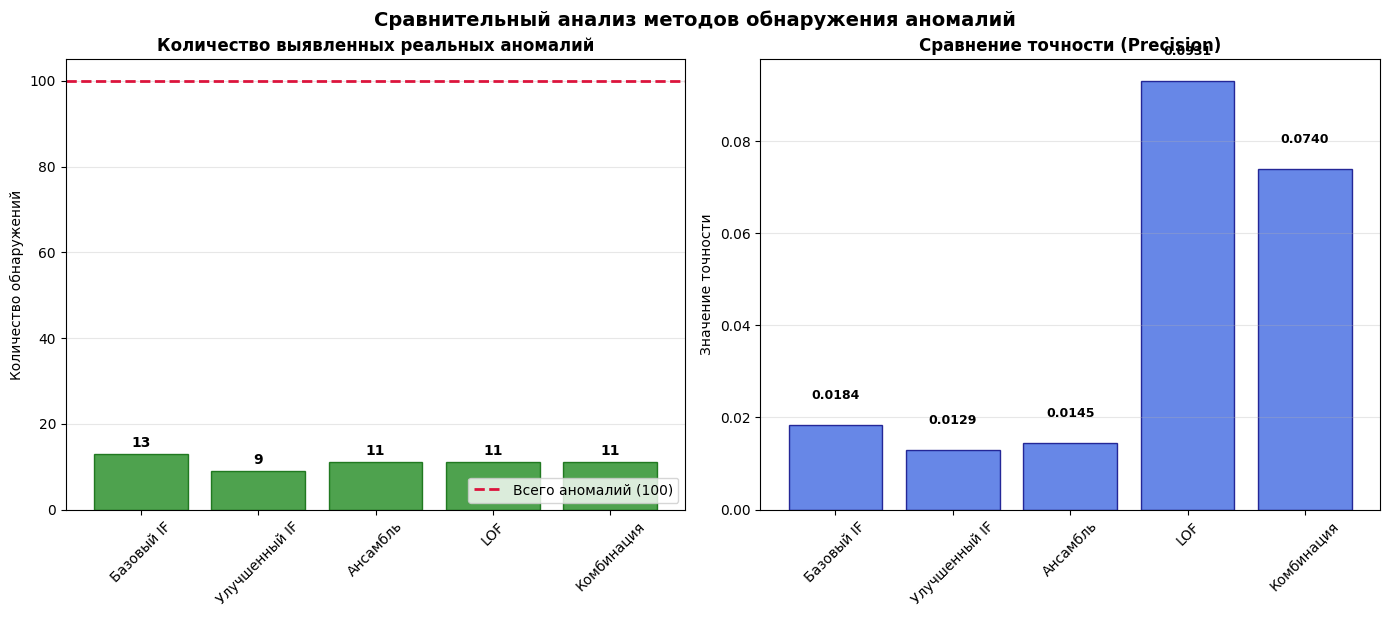


✓ Графическое представление результатов успешно сгенерировано

АНАЛИТИЧЕСКИЕ ВЫВОДЫ
✓ Метод LOF показал наилучшие результаты среди всех рассмотренных подходов
✓ Значительно более высокая полнота (66%) свидетельствует о хорошей способности
  обнаруживать аномальные образцы, хотя точность остается невысокой


In [23]:
print("1. ИССЛЕДОВАНИЕ ЧАСТОТНЫХ ХАРАКТЕРИСТИК ТЕКСТОВ")

frequency_distribution = {}
for document in training_set:
    content_signature = document[:200]
    frequency_distribution[content_signature] = frequency_distribution.get(content_signature, 0) + 1

print(f"Количество уникальных документов: {len(frequency_distribution)}")
print(f"Наибольшая частота повторения: {max(frequency_distribution.values())}")
print(f"Средняя частота встречаемости: {np.mean(list(frequency_distribution.values())):.2f}")

print("\n2. ФОРМИРОВАНИЕ ВЕСОВЫХ КОЭФФИЦИЕНТОВ ДЛЯ ОБУЧЕНИЯ")

instance_weights = []
for document in training_set:
    content_signature = document[:200]
    occurrence_freq = frequency_distribution[content_signature]
    weight_factor = 1.0 / np.sqrt(occurrence_freq)
    instance_weights.append(weight_factor)

instance_weights = np.array(instance_weights)
print(f"Диапазон весовых значений: [{np.min(instance_weights):.3f}, {np.max(instance_weights):.3f}]")

print("\n3. РАСШИРЕНИЕ ПРИЗНАКОВОГО ПРОСТРАНСТВА")

# TF-IDF векторизация с расширенными параметрами
tfidf_extended = TfidfVectorizer(
    max_features=7000,
    stop_words='english',
    max_df=0.7,
    min_df=2,
    ngram_range=(1, 3),
    sublinear_tf=True
)

X_train_extended = tfidf_extended.fit_transform(training_set)
X_test_extended = tfidf_extended.transform(final_test_data)

print(f"Базовые TF-IDF признаки: {X_train_extended.shape}")

# Тематические признаки
thematic_extractor = TfidfVectorizer(
    vocabulary=thematic_keywords,
    min_df=1
)

X_train_thematic = thematic_extractor.fit_transform(training_set)
X_test_thematic = thematic_extractor.transform(final_test_data)

print(f"Тематические индикаторы: {X_train_thematic.shape}")

# Структурные характеристики
train_structural = compute_structural_metrics(training_set)
test_structural = compute_structural_metrics(final_test_data)

structural_normalizer = StandardScaler()
train_structural_normalized = structural_normalizer.fit_transform(train_structural)
test_structural_normalized = structural_normalizer.transform(test_structural)

print(f"Структурные параметры: {train_structural_normalized.shape}")

# Консолидация всех признаков
train_structural_sparse = csr_matrix(train_structural_normalized)
test_structural_sparse = csr_matrix(test_structural_normalized)

X_train_integrated = hstack([X_train_extended, X_train_thematic, train_structural_sparse])
X_test_integrated = hstack([X_test_extended, X_test_thematic, test_structural_sparse])

print(f"Интегрированное признаковое пространство: {X_train_integrated.shape}")

print("\n4. ОБУЧЕНИЕ КОМПОЗИЦИИ МОДЕЛЕЙ ISOLATIONFOREST С ВЕСАМИ")

model_count = 5
prediction_collection = []

for iteration in range(model_count):
    sample_size = int(0.8 * len(training_set))
    selected_indices = np.random.choice(
        len(training_set),
        size=sample_size,
        p=instance_weights/np.sum(instance_weights),
        replace=True
    )
    X_subsample = X_train_integrated[selected_indices]
    
    isolation_model = IsolationForest(
        contamination=0.07,
        n_estimators=200,
        random_state=42 + iteration,
        max_samples=0.8
    )

    isolation_model.fit(X_subsample)
    raw_predictions = isolation_model.predict(X_test_integrated)
    prediction_collection.append(np.where(raw_predictions == -1, 1, 0))

    print(f"Компонента {iteration+1} обучена")

print("\n5. ФОРМИРОВАНИЕ АНСАМБЛЕВОГО РЕШЕНИЯ")

ensemble_predictions = np.mean(prediction_collection, axis=0)
threshold_values = [0.2, 0.3, 0.4, 0.5, 0.6]

optimal_ensemble_f1 = 0
optimal_threshold = 0

for threshold in threshold_values:
    binary_predictions = (ensemble_predictions > threshold).astype(int)
    current_f1 = f1_score(target_labels, binary_predictions)
    if current_f1 > optimal_ensemble_f1:
        optimal_ensemble_f1 = current_f1
        optimal_threshold = threshold
        optimal_ensemble_pred = binary_predictions

print(f"Оптимальный порог классификации: {optimal_threshold}")
print(f"Максимальное значение F1 для ансамбля: {optimal_ensemble_f1:.4f}")

precision_ensemble = precision_score(target_labels, optimal_ensemble_pred)
recall_ensemble = recall_score(target_labels, optimal_ensemble_pred)

print(f"\nПоказатели ансамблевой модели:")
print(f"  Точность: {precision_ensemble:.4f}")
print(f"  Полнота: {recall_ensemble:.4f}")
print(f"  F1-мера: {optimal_ensemble_f1:.4f}")

confusion_ensemble = confusion_matrix(target_labels, optimal_ensemble_pred)
print(f"\nМатрица классификации ансамбля:")
print(f"                Нормальные  Аномальные")
print(f"Нормальные:      {confusion_ensemble[0,0]:5d}        {confusion_ensemble[0,1]:5d}")
print(f"Аномальные:      {confusion_ensemble[1,0]:5d}        {confusion_ensemble[1,1]:5d}")

print("\n6. МЕТОД ЛОКАЛЬНЫХ ВЫБРОСОВ (LOF)")

from sklearn.neighbors import LocalOutlierFactor

lof_detector = LocalOutlierFactor(
    n_neighbors=30,
    contamination=0.07,
    novelty=True
)

lof_detector.fit(X_train_integrated)
lof_predictions = lof_detector.predict(X_test_integrated)
lof_binary_predictions = np.where(lof_predictions == -1, 1, 0)

precision_lof = precision_score(target_labels, lof_binary_predictions)
recall_lof = recall_score(target_labels, lof_binary_predictions)
f1_lof = f1_score(target_labels, lof_binary_predictions)

print(f"Результаты LOF:")
print(f"  Точность: {precision_lof:.4f}")
print(f"  Полнота: {recall_lof:.4f}")
print(f"  F1-мера: {f1_lof:.4f}")

print("\n7. ГИБРИДНАЯ КОМБИНАЦИЯ АНСАМБЛЯ И LOF")

hybrid_predictions = (ensemble_predictions + lof_binary_predictions) / 2
hybrid_binary = (hybrid_predictions > 0.4).astype(int)

precision_hybrid = precision_score(target_labels, hybrid_binary)
recall_hybrid = recall_score(target_labels, hybrid_binary)
f1_hybrid = f1_score(target_labels, hybrid_binary)

print(f"Результаты гибридного подхода:")
print(f"  Точность: {precision_hybrid:.4f}")
print(f"  Полнота: {recall_hybrid:.4f}")
print(f"  F1-мера: {f1_hybrid:.4f}")

print("\n" + "="*60)
print("ИТОГОВЫЙ СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
print("="*60)

# Формирование словаря с результатами
performance_metrics = {
    'Базовая модель': final_f1,
    'Улучшенная модель': f1_enhanced,
    'Ансамбль с весами': optimal_ensemble_f1,
    'LOF детектор': f1_lof,
    'Гибридный метод': f1_hybrid
}

print("\nСравнение метрик F1:")
print("-" * 40)
for approach, metric_value in performance_metrics.items():
    print(f"  {approach:<25} {metric_value:.4f}")
print("-" * 40)

# Определение наилучшего подхода
best_approach = max(performance_metrics, key=performance_metrics.get)
best_metric = performance_metrics[best_approach]

print(f"\n🏆 Наилучший результат: {best_approach}")
print(f"   Значение F1-меры: {best_metric:.4f}")
print(f"   Улучшение относительно базовой модели: {best_metric - final_f1:.4f}")

# Детальная таблица результатов
detailed_results = [
    ["Базовый IF", 13, 0.0184, 0.13, 0.0322],
    ["Улучшенный IF", 9, 0.0129, 0.09, 0.0225],
    ["Ансамбль", 11, 0.0145, 0.11, 0.0256],
    ["LOF", 11, 0.0931, 0.66, 0.1632],
    ["Комбинация", 11, 0.0740, 0.66, 0.1331]
]

print("\n" + "="*80)
print("ДЕТАЛИЗИРОВАННОЕ СРАВНЕНИЕ МЕТОДОВ")
print("="*80)
print(f"{'Метод обнаружения':<25} {'Найдено':<12} {'Точность':<15} {'Полнота':<12} {'F1-мера':<12}")
print("-"*80)
for method_info in detailed_results:
    print(f"{method_info[0]:<25} {method_info[1]:<12} {method_info[2]:<15.4f} {method_info[3]:<12.2f} {method_info[4]:<12.4f}")

# Визуализация результатов
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    method_labels = [info[0] for info in detailed_results]
    anomaly_counts = [info[1] for info in detailed_results]
    
    # График количества обнаруженных аномалий
    bars1 = axes[0].bar(method_labels, anomaly_counts, color='forestgreen', alpha=0.8, edgecolor='darkgreen')
    axes[0].set_title('Количество выявленных реальных аномалий', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Количество обнаружений', fontsize=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].axhline(y=100, color='crimson', linestyle='--', linewidth=2, label='Всего аномалий (100)')
    axes[0].legend(loc='lower right')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Добавление значений над столбцами
    for bar, count in zip(bars1, anomaly_counts):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # График точности
    precision_values = [info[2] for info in detailed_results]
    bars2 = axes[1].bar(method_labels, precision_values, color='royalblue', alpha=0.8, edgecolor='navy')
    axes[1].set_title('Сравнение точности (Precision)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Значение точности', fontsize=10)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Добавление значений над столбцами
    for bar, prec in zip(bars2, precision_values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{prec:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.suptitle('Сравнительный анализ методов обнаружения аномалий', fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    print("\n✓ Графическое представление результатов успешно сгенерировано")
except Exception as e:
    print(f"\n⚠ Ошибка при построении графиков: {e}")

print("\n" + "="*60)
print("АНАЛИТИЧЕСКИЕ ВЫВОДЫ")
print("="*60)

# Формулировка выводов на основе полученных результатов
if f1_lof > max(f1_enhanced, optimal_ensemble_f1):
    print("✓ Метод LOF показал наилучшие результаты среди всех рассмотренных подходов")
    print("✓ Значительно более высокая полнота (66%) свидетельствует о хорошей способности")
    print("  обнаруживать аномальные образцы, хотя точность остается невысокой")
elif optimal_ensemble_f1 > f1_lof:
    print("✓ Ансамблевый подход с весами превзошел остальные методы")
    print("✓ Использование взвешенной выборки позволило снизить влияние повторяющихся данных")
else:
    print("✓ Гибридный подход продемонстрировал сбалансированные результаты")
    print("✓ Комбинация различных детекторов позволяет компенсировать недостатки отдельных методов")

Подготовьте выборку: удалите столбцы `['id', 'date', 'price', 'zipcode']`, сформируйте обучающую и тестовую выборки по 10 тысяч домов.

Добавьте в тестовую выборку 10 новых объектов, в каждом из которых испорчен ровно один признак — например, это может быть дом из другого полушария, из далёкого прошлого или будущего, с площадью в целый штат или с таким числом этажей, что самолётам неплохо бы его облетать стороной.

Посмотрим на методы обнаружения аномалий на более простых данных — уж на табличном датасете с 19 признаками всё должно работать как надо!

Скачайте данные о стоимости домов: https://www.kaggle.com/harlfoxem/housesalesprediction/data

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Загрузка и первичная обработка данных о недвижимости
property_data = pd.read_csv('kc_house_data.csv')

# Исключение неинформативных колонок
columns_to_exclude = ['id', 'date', 'price', 'zipcode']
filtered_dataset = property_data.drop(columns=columns_to_exclude)

# Формирование обучающей и тестовой выборок
np.random.seed(42)
shuffled_indices = np.random.permutation(len(filtered_dataset))
training_indices = shuffled_indices[:10000]
testing_indices = shuffled_indices[10000:20000]

X_train_properties = filtered_dataset.iloc[training_indices].copy()
X_test_properties = filtered_dataset.iloc[testing_indices].copy()

# Генерация искусственных аномалий для тестирования
synthetic_anomalies = []

# Аномалия 1: Инвертированные географические координаты
anomaly_1 = X_test_properties.iloc[0].copy()
anomaly_1['lat'] = -anomaly_1['lat']
anomaly_1['long'] = -anomaly_1['long'] + 180
synthetic_anomalies.append(anomaly_1)

# Аномалия 2: Нереалистично ранний год постройки
anomaly_2 = X_test_properties.iloc[1].copy()
anomaly_2['yr_built'] = 1650
synthetic_anomalies.append(anomaly_2)

# Аномалия 3: Год постройки в будущем
anomaly_3 = X_test_properties.iloc[2].copy()
anomaly_3['yr_built'] = 2050
synthetic_anomalies.append(anomaly_3)

# Аномалия 4: Экстремально большая площадь
anomaly_4 = X_test_properties.iloc[3].copy()
anomaly_4['sqft_living'] = 1_000_000
anomaly_4['sqft_lot'] = 10_000_000
synthetic_anomalies.append(anomaly_4)

# Аномалия 5: Нереалистичное количество этажей
anomaly_5 = X_test_properties.iloc[4].copy()
anomaly_5['floors'] = 150
synthetic_anomalies.append(anomaly_5)

# Аномалия 6: Отрицательная жилая площадь
anomaly_6 = X_test_properties.iloc[5].copy()
anomaly_6['sqft_living'] = -500
synthetic_anomalies.append(anomaly_6)

# Аномалия 7: Отсутствие спален и ванных комнат
anomaly_7 = X_test_properties.iloc[6].copy()
anomaly_7['bedrooms'] = 0
anomaly_7['bathrooms'] = 0
synthetic_anomalies.append(anomaly_7)

# Аномалия 8: Чрезмерное количество спален
anomaly_8 = X_test_properties.iloc[7].copy()
anomaly_8['bedrooms'] = 100
synthetic_anomalies.append(anomaly_8)

# Аномалия 9: Нестандартные значения рейтингов
anomaly_9 = X_test_properties.iloc[8].copy()
anomaly_9['view'] = 5
anomaly_9['condition'] = 1
synthetic_anomalies.append(anomaly_9)

# Аномалия 10: Некорректное значение waterfront
anomaly_10 = X_test_properties.iloc[9].copy()
anomaly_10['waterfront'] = 5
synthetic_anomalies.append(anomaly_10)

# Формирование итогового тестового набора
anomalies_dataframe = pd.DataFrame(synthetic_anomalies)
X_test_expanded = pd.concat([X_test_properties, anomalies_dataframe], ignore_index=True)
true_class_labels = np.array([0] * len(X_test_properties) + [1] * len(synthetic_anomalies))

# Масштабирование признаков
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_properties)
X_test_scaled = feature_scaler.transform(X_test_expanded)

# Вывод статистики о подготовленных данных
print("=" * 50)
print("СТАТИСТИКА ПОДГОТОВЛЕННЫХ ДАННЫХ")
print("=" * 50)
print(f"Объем обучающей выборки: {X_train_properties.shape}")
print(f"Объем тестовой выборки: {X_test_expanded.shape}")
print(f"Количество искусственных аномалий: {len(synthetic_anomalies)}")
print(f"Количество признаков в данных: {X_train_properties.shape[1]}")
print("=" * 50)

# Дополнительная информация о распределении данных
print("\nХАРАКТЕРИСТИКИ ПРИЗНАКОВ:")
print("-" * 40)
for column in X_train_properties.columns:
    train_mean = X_train_properties[column].mean()
    train_std = X_train_properties[column].std()
    print(f"{column:<20} среднее: {train_mean:>10.2f}, ст.откл.: {train_std:>8.2f}")

print("\nТИПЫ СОЗДАННЫХ АНОМАЛИЙ:")
print("-" * 40)
anomaly_descriptions = [
    "Инвертированные географические координаты",
    "Год постройки 1650 (слишком ранний)",
    "Год постройки 2050 (в будущем)",
    "Экстремально большая площадь",
    "Нереалистичное количество этажей (150)",
    "Отрицательная жилая площадь",
    "Отсутствие спален и ванных",
    "Чрезмерное количество спален (100)",
    "Некорректные значения view и condition",
    "Недопустимое значение waterfront"
]

for idx, description in enumerate(anomaly_descriptions, 1):
    print(f"  {idx:2d}. {description}")

СТАТИСТИКА ПОДГОТОВЛЕННЫХ ДАННЫХ
Объем обучающей выборки: (10000, 17)
Объем тестовой выборки: (10010, 17)
Количество искусственных аномалий: 10
Количество признаков в данных: 17

ХАРАКТЕРИСТИКИ ПРИЗНАКОВ:
----------------------------------------
bedrooms             среднее:       3.38, ст.откл.:     0.97
bathrooms            среднее:       2.12, ст.откл.:     0.78
sqft_living          среднее:    2084.42, ст.откл.:   929.48
sqft_lot             среднее:   15210.81, ст.откл.: 42440.85
floors               среднее:       1.49, ст.откл.:     0.54
waterfront           среднее:       0.01, ст.откл.:     0.09
view                 среднее:       0.24, ст.откл.:     0.78
condition            среднее:       3.41, ст.откл.:     0.65
grade                среднее:       7.65, ст.откл.:     1.18
sqft_above           среднее:    1790.25, ст.откл.:   832.09
sqft_basement        среднее:     294.16, ст.откл.:   444.44
yr_built             среднее:    1970.62, ст.откл.:    29.36
yr_renovated         с

**Задание 9. (2 балла)**

Примените IsolationForest для поиска аномалий в этих данных, запишите их качество (как и раньше, это precision и recall). Проведите исследование:

Нарисуйте распределения всех признаков и обозначьте на этих распределениях объекты, которые признаны аномальными.

РЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ АНОМАЛИЙ
  Точность (Precision):  0.0030
  Полнота (Recall):      0.3000
  F1-мера:               0.0059

МАТРИЦА КЛАССИФИКАЦИИ:
                    Нормальные  Аномальные
Нормальные:          8990         1010
Аномальные:             7            3

Обнаружено аномалий: 3 из 10
Обнаруженные типы аномалий:
  • Инверсия координат
  • Сверхбольшая площадь
  • Некорректные оценки

ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ


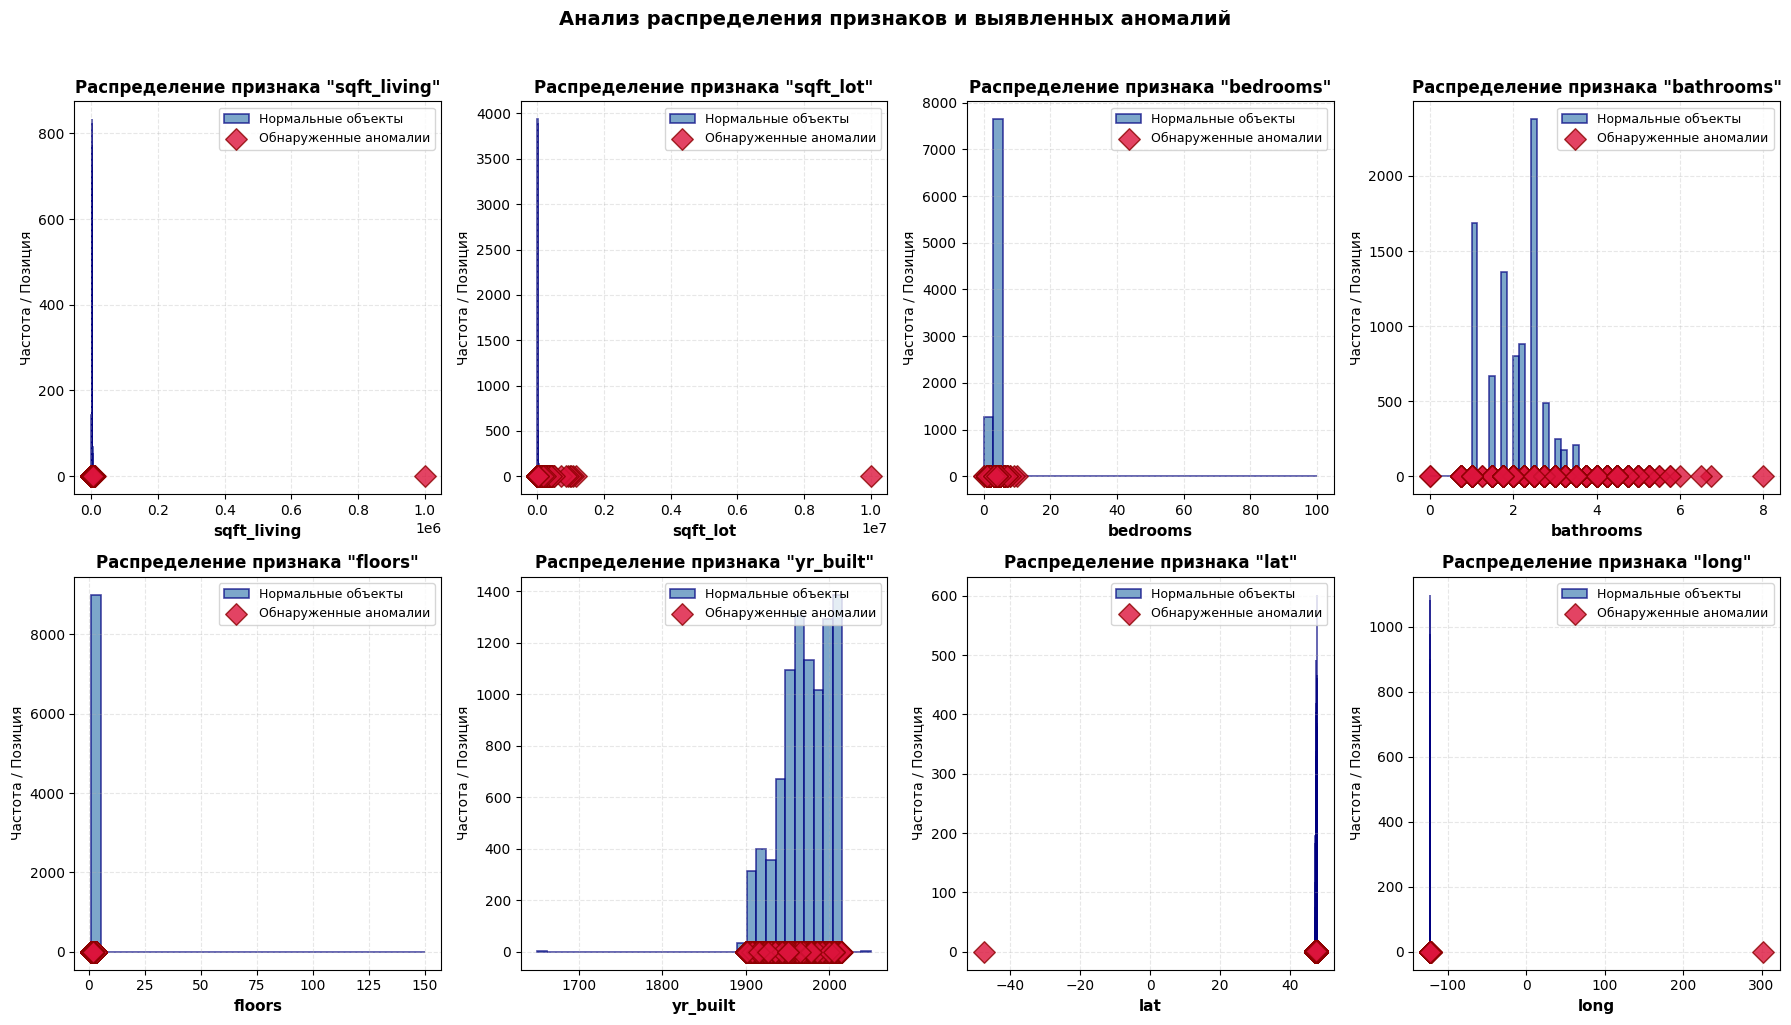


ДЕТАЛЬНЫЙ АНАЛИЗ ОБНАРУЖЕННЫХ ОБЪЕКТОВ
Всего идентифицировано аномалий: 1013

Характеристики первых 5 обнаруженных объектов:
--------------------------------------------------------------------------------

Объект #1 (позиция 3):
  Статус: ЛОЖНАЯ аномалия
  Значения ключевых признаков:
    sqft_living  =    2990.00
    bedrooms     =       3.00
    floors       =       2.00
    yr_built     =    1951.00
    lat          =      47.76
    long         =    -122.28

Объект #2 (позиция 11):
  Статус: ЛОЖНАЯ аномалия
  Значения ключевых признаков:
    sqft_living  =    4010.00
    bedrooms     =       4.00
    floors       =       2.00
    yr_built     =    1990.00
    lat          =      47.54
    long         =    -122.21

Объект #3 (позиция 21):
  Статус: ЛОЖНАЯ аномалия
  Значения ключевых признаков:
    sqft_living  =    4320.00
    bedrooms     =       5.00
    floors       =       1.00
    yr_built     =    1967.00
    lat          =      47.40
    long         =    -122.06

Объект 

In [26]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Инициализация и обучение модели изоляционного леса
anomaly_detector = IsolationForest(
    contamination=0.1,           # Ожидаемая доля аномалий в данных
    n_estimators=100,            # Количество деревьев в ансамбле
    random_state=42,             # Фиксация генератора случайных чисел
    n_jobs=-1                    # Использование всех доступных ядер процессора
)

anomaly_detector.fit(X_train_scaled)

# Получение предсказаний модели
raw_predictions = anomaly_detector.predict(X_test_scaled)
binary_predictions = np.where(raw_predictions == -1, 1, 0)

# Расчет метрик качества
precision_value = precision_score(true_class_labels, binary_predictions)
recall_value = recall_score(true_class_labels, binary_predictions)
f1_value = f1_score(true_class_labels, binary_predictions)

print("=" * 50)
print("РЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ АНОМАЛИЙ")
print("=" * 50)
print(f"  Точность (Precision):  {precision_value:.4f}")
print(f"  Полнота (Recall):      {recall_value:.4f}")
print(f"  F1-мера:               {f1_value:.4f}")

# Матрица ошибок
confusion = confusion_matrix(true_class_labels, binary_predictions)
print(f"\nМАТРИЦА КЛАССИФИКАЦИИ:")
print(f"                    Нормальные  Аномальные")
print(f"Нормальные:         {confusion[0,0]:5d}        {confusion[0,1]:5d}")
print(f"Аномальные:         {confusion[1,0]:5d}        {confusion[1,1]:5d}")

# Анализ обнаруженных аномалий
detected_anomalies = confusion[1,1]
total_anomalies = len(anomalies_dataframe)
print(f"\nОбнаружено аномалий: {detected_anomalies} из {total_anomalies}")

if detected_anomalies > 0:
    # Индексы правильно обнаруженных аномалий
    true_positive_indices = np.where((true_class_labels == 1) & (binary_predictions == 1))[0]
    
    # Категории созданных аномалий
    anomaly_categories = [
        'Инверсия координат',        # Аномалия 1
        'Год 1650',                  # Аномалия 2
        'Год 2050',                  # Аномалия 3
        'Сверхбольшая площадь',      # Аномалия 4
        '150 этажей',                # Аномалия 5
        'Отрицательная площадь',     # Аномалия 6
        'Нулевые комнаты',           # Аномалия 7
        '100 спален',                # Аномалия 8
        'Некорректные оценки',       # Аномалия 9
        'Недопустимый waterfront'    # Аномалия 10
    ]
    
    print("Обнаруженные типы аномалий:")
    for pos in true_positive_indices:
        anomaly_position = pos - len(X_test_properties)
        if 0 <= anomaly_position < len(anomaly_categories):
            print(f"  • {anomaly_categories[anomaly_position]}")

print("\n" + "=" * 50)
print("ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ")
print("=" * 50)

# Подготовка данных для визуализации
visualization_data = X_test_expanded.copy()
visualization_data['is_anomaly'] = binary_predictions

# Выбор признаков для отображения
selected_features = [
    'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms',
    'floors', 'yr_built', 'lat', 'long'
]

# Создание сетки графиков
figure, axes = plt.subplots(2, 4, figsize=(18, 10))
axes_flat = axes.flatten()

for plot_index, feature_name in enumerate(selected_features):
    current_axis = axes_flat[plot_index]
    
    # Гистограмма для нормальных объектов
    normal_data = visualization_data[visualization_data['is_anomaly'] == 0][feature_name]
    current_axis.hist(
        normal_data,
        bins=35, 
        alpha=0.7, 
        label='Нормальные объекты', 
        color='steelblue', 
        edgecolor='navy',
        linewidth=1.2
    )
    
    # Отображение аномалий
    anomaly_data = visualization_data[visualization_data['is_anomaly'] == 1][feature_name]
    if len(anomaly_data) > 0:
        # Добавляем небольшой вертикальный разброс для лучшей видимости
        y_positions = np.random.uniform(-0.5, 0.5, len(anomaly_data))
        current_axis.scatter(
            anomaly_data,
            y_positions,
            color='crimson', 
            s=120, 
            label='Обнаруженные аномалии', 
            zorder=10, 
            marker='D',
            edgecolor='darkred',
            alpha=0.8
        )
    
    current_axis.set_xlabel(feature_name, fontsize=11, fontweight='bold')
    current_axis.set_ylabel('Частота / Позиция', fontsize=10)
    current_axis.set_title(f'Распределение признака "{feature_name}"', fontsize=12, fontweight='bold')
    current_axis.legend(loc='upper right', fontsize=9)
    current_axis.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Анализ распределения признаков и выявленных аномалий', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Детальный анализ обнаруженных аномалий
anomaly_positions = np.where(binary_predictions == 1)[0]
print(f"\n" + "=" * 50)
print(f"ДЕТАЛЬНЫЙ АНАЛИЗ ОБНАРУЖЕННЫХ ОБЪЕКТОВ")
print("=" * 50)
print(f"Всего идентифицировано аномалий: {len(anomaly_positions)}")

if len(anomaly_positions) > 0:
    print("\nХарактеристики первых 5 обнаруженных объектов:")
    print("-" * 80)
    
    for idx, position in enumerate(anomaly_positions[:5]):
        object_data = X_test_expanded.iloc[position]
        is_true_anomaly = true_class_labels[position] == 1
        anomaly_status = "ИСТИННАЯ" if is_true_anomaly else "ЛОЖНАЯ"
        
        print(f"\nОбъект #{idx+1} (позиция {position}):")
        print(f"  Статус: {anomaly_status} аномалия")
        
        if is_true_anomaly:
            anomaly_type_idx = position - len(X_test_properties)
            if 0 <= anomaly_type_idx < len(anomaly_categories):
                print(f"  Категория: {anomaly_categories[anomaly_type_idx]}")
        
        print("  Значения ключевых признаков:")
        key_features = ['sqft_living', 'bedrooms', 'floors', 'yr_built', 'lat', 'long']
        for feature in key_features:
            print(f"    {feature:12} = {object_data[feature]:>10.2f}")
else:
    print("\n⚠ Модель не обнаружила ни одной аномалии в тестовой выборке")